# <center>Sklearn之逻辑回归</center>

# 1 逻辑回归介绍

- **[逻辑回归初步](https://blog.csdn.net/han_xiaoyang/article/details/49123419)**
- **[从初等数学角度解读逻辑回归](https://blog.csdn.net/han_xiaoyang/article/details/49332321)**

# 2 Kaggle泰坦尼克之灾

## 2.1 kaggle介绍

[Kaggle](https://www.kaggle.com/)是一个数据分析建模的应用竞赛平台，有点类似于[KDD（国际知识发现和数据挖掘竞赛）](https://www.kdd.org/)，企业或研究者可以将问题**背景**、**数据**、**期望指标**等发布到Kaggle，以竞赛的形式向广大数据科学家征集解决方案。

## 2.2 泰坦尼克之灾介绍

[Kaggle Titanic介绍](https://www.kaggle.com/c/titanic/overview)

泰坦尼克号问题背景：
- 逃生问题：救生艇数量有限，无法人人都有，副船长发话女士和小孩优先，所以**是否被营救并非随机，而是基于一些背景排名先后的**。
- 训练集和测试集是一些乘客的个人信息以及存活情况（训练集），要尝试更具它生成合适的模型来**预测其他人的存货情况（测试集）**。
- 这是一个二分类问题，可以用**Logistic Regression**来处理。

# 3 数据处理

## 3.1 数据处理和可视化准备

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 3.2 数据初探

### 3.2.1 加载数据

In [25]:
# 加载训练集数据
data_train = pd.read_csv('./data/lgregression/train.csv')
data_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

字段解释：
- PassengerId：乘客ID
- Survived：是否获救（1是/0否)
- Pclass：乘客等级（1/2/3等仓位）
- Name：乘客姓名
- Sex：乘客性别
- Age：乘客年龄
- Sibsp：堂兄弟/妹个数
- Parch：父母与小孩个数
- Ticket：船票信息
- Fare：票价
- Cabin：客舱
- Embarked：登船港口

### 3.2.2 整体数据信息

In [26]:
# 数据信息
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


由上可知，训练集数据一共由891条记录，即891名乘客。发现有些缺失数据：
- Age属性只有714名乘客有记录
- Cabin属性只有204名乘客有记录

### 3.2.3 数据的统计描述

In [27]:
# 整体数据统计描述
data_train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

统计描述会自动过滤掉非数值属性，只统计数值型属性。由上可以知道一些信息：
- 平均获救人数为0.383838人
- 2/3等仓的人数要比1等仓人数多
- 乘客的平均年龄为29.7岁（有记录的乘客）
- 平均票价为32.20美元，并且有免费票

## 3.3 数据初步分析

乘客有这么多属性，哪些属性有用？该如何使用？所以需要对数据有清晰的认识（**数据的认识**）。在上面对数据整体有一个认识后，再从属性的角度深入认识一下数据，观察**每个/多个属性和Survived之间有什么样的关系**

### 3.3.1 乘客属性分布

通过图形来观察数据要比直接观察数据要直观、有效率的多。
- 乘客获救情况
- 乘客等级分布
- 按照年龄划分，乘客获救情况（只统计有记录的）
- 各等级乘客年龄的分布
- 各港口登船人数分布

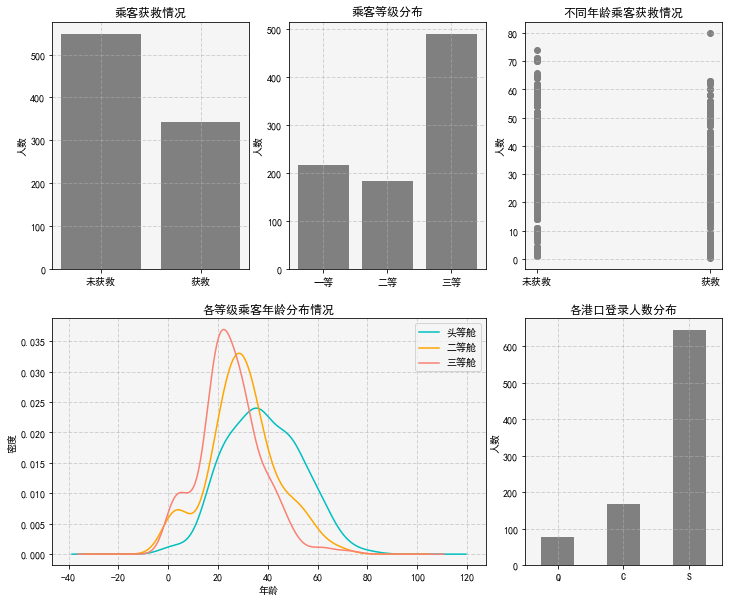

In [28]:
# 设置画布
plt.figure(figsize=(12,10))

# 乘客获救情况
survived = data_train.Survived.value_counts()
plt.subplot2grid((2, 3), (0, 0))
plt.gca().set_facecolor('whitesmoke')
plt.bar(survived.index, survived.values, width=0.8, color='gray')
plt.title('乘客获救情况')
plt.xticks([0, 1], ('未获救', '获救'))
plt.ylabel('人数')
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

# 乘客等级分布
pclass = data_train.Pclass.value_counts().sort_index()
plt.subplot2grid((2, 3), (0, 1))
plt.gca().set_facecolor('whitesmoke')
plt.bar(pclass.index, pclass.values, color='gray')
plt.title('乘客等级分布')
plt.xticks([1, 2, 3], ('一等', '二等', '三等'))
plt.ylabel('人数')
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

# 不同年龄乘客获救情况
plt.subplot2grid((2, 3), (0, 2))
plt.gca().set_facecolor('whitesmoke')
plt.scatter(data_train.Survived, data_train.Age, color='gray')
plt.title('不同年龄乘客获救情况')
plt.xticks([0, 1], ('未获救', '获救'))
plt.ylabel('人数')
plt.grid(linestyle='--', linewidth=1, alpha=0.5, axis='y')

# 各等级乘客年龄的分布
plt.subplot2grid((2, 3), (1, 0), colspan=2)
plt.gca().set_facecolor('whitesmoke')
data_train[data_train.Pclass==1].Age.plot(kind='kde', color='c', label='头等舱')
data_train[data_train.Pclass==2].Age.plot(kind='kde', color='orange', label='二等舱')
data_train[data_train.Pclass==3].Age.plot(kind='kde', color='salmon', label='三等舱')
plt.title('各等级乘客年龄分布情况')
plt.xlabel('年龄')
plt.ylabel('密度')
plt.legend(facecolor='whitesmoke')
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

# 各港口登船人数分布
embarked = data_train.Embarked.value_counts().sort_values()
plt.subplot2grid((2, 3), (1, 2))
plt.gca().set_facecolor('whitesmoke')
embarked.plot(kind='bar', color='gray')
plt.title('各港口登录人数分布')
plt.xticks(rotation=360)
plt.ylabel('人数')
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

从上图可以看出，被救人数300多一点，不到总人数半数。三等舱人数远多于1/2等仓；遇难和获救乘客年龄跨度都很广；三个不同仓，年龄总体趋势大致相同，2/3等仓20岁左右乘客人数最多，头等舱40岁左右乘客人数最多；港口登船人数从Q、C、S依次递增，其中S港口登船人数，远多于其它两个港口。基于以上分析，提出猜想：
- 不同仓位/乘客等级可能和财富/地位有关，最后获救的概率可能不一样
- 年龄对获救概率一定也有影响
- 和登船港口是不是也有关系，也许登船港口不同，人出生地位不同（VIP通道？）

### 3.3.2 属性与获救结果的关联统计

**查看各等级乘客的获救情况：**

In [29]:
# 乘客等级和是否获救的透视表
pclass_survived_pivot = data_train.pivot_table(values='PassengerId', index=['Pclass'], columns=['Survived'], aggfunc='count', margins=True)
pclass_survived_pivot

Survived    0    1  All
Pclass                 
1          80  136  216
2          97   87  184
3         372  119  491
All       549  342  891

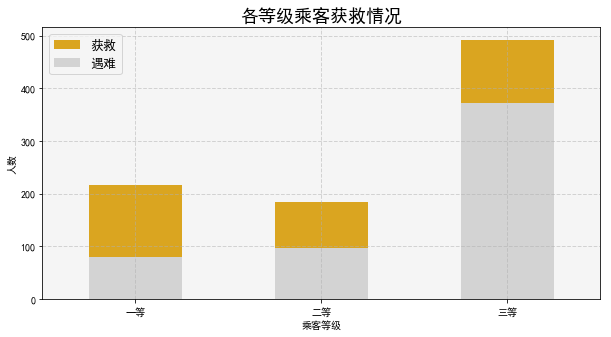

In [30]:
# 画出各等级乘客是否获救的堆积柱形图
plt.figure(figsize=(10, 5))
plt.gca().set_facecolor('whitesmoke')
pclass_survived_pivot.iloc[0:3, 2].plot(kind='bar', color='goldenrod', label='获救')
pclass_survived_pivot.iloc[0:3, 0].plot(kind='bar', color='lightgrey', label='遇难')
plt.title('各等级乘客获救情况', fontsize=18)
plt.xticks([0, 1, 2], ('一等', '二等', '三等'), rotation=360)
plt.xlabel('乘客等级')
plt.ylabel('人数')
plt.legend(facecolor='whitesmoke', fontsize=13)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

由上图可以看出，明显一等舱乘客获救的概率更高。乘客等级一定是影响最后获救结果的一个特征。

**查看各性别乘客的获救情况：**

In [31]:
# 乘客性别和获救情况的数据透视表
gender_survived_pivot = data_train.pivot_table(values='PassengerId', index=['Sex'], columns=['Survived'], aggfunc='count', margins=True)
gender_survived_pivot.head()

Survived    0    1  All
Sex                    
female     81  233  314
male      468  109  577
All       549  342  891

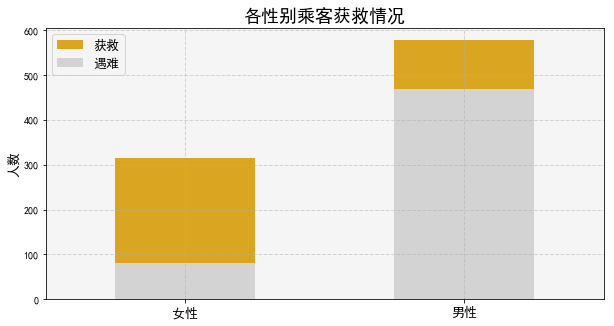

In [32]:
# 画出各性别获救情况的堆积柱形图
plt.figure(figsize=(10, 5))
plt.gca().set_facecolor('whitesmoke')
gender_survived_pivot.iloc[0:2, 2].plot(kind='bar', color='goldenrod', label='获救')
gender_survived_pivot.iloc[0:2, 0].plot(kind='bar', color='lightgrey', label='遇难')
plt.title('各性别乘客获救情况', fontsize=18)
plt.xticks([0, 1], ('女性', '男性'), rotation=360, fontsize=13)
plt.xlabel('')
plt.ylabel('人数', fontsize=13)
plt.legend(facecolor='whitesmoke', loc=2, fontsize=13)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

女性获救的比例明显高于男性，正好符号开始船长所说的**女士和小孩优先**，乘客性别无疑也要作为特征加如到最后的模型中。

**根据船舱等级和乘客性别来查看获救情况：**

In [33]:
# 船舱等级和乘客性别作为分类的获救情况
pclass_gender_sv_pivot = data_train.pivot_table(values='PassengerId', index=['Pclass', 'Survived'], columns=['Sex'], aggfunc='count')
pclass_gender_sv_pivot

Sex              female  male
Pclass Survived              
1      0              3    77
       1             91    45
2      0              6    91
       1             70    17
3      0             72   300
       1             72    47

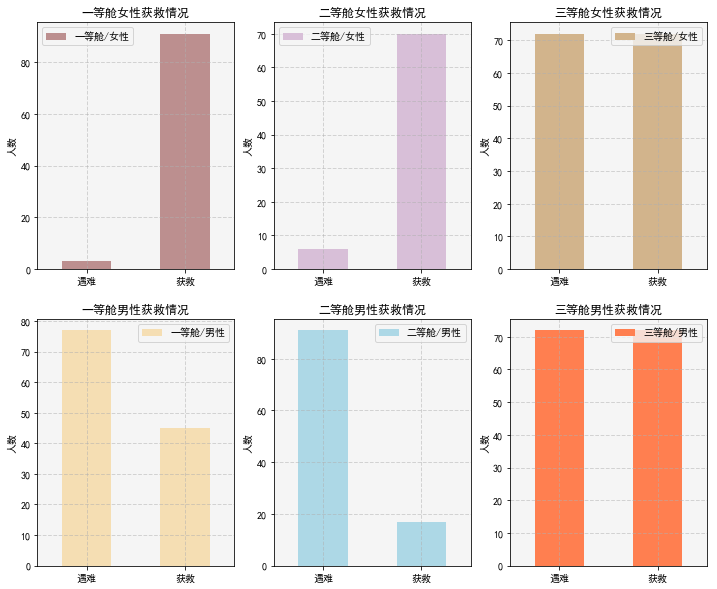

In [34]:
# 分别画出各船舱不同性别乘客的获救情况
plt.figure(figsize=(12, 10))

# 一等舱女性获救情况
plt.subplot(2, 3, 1)
plt.gca().set_facecolor('whitesmoke')
pclass_gender_sv_pivot.iloc[0:2, 0].plot(kind='bar', color='rosybrown', label='一等舱/女性')
plt.title('一等舱女性获救情况')
plt.xticks([0, 1], ('遇难', '获救'), rotation=0)
plt.xlabel('')
plt.ylabel('人数')
plt.legend(facecolor='whitesmoke')
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

# 二等舱女性获救情况
plt.subplot(2, 3, 2)
plt.gca().set_facecolor('whitesmoke')
pclass_gender_sv_pivot.iloc[2:4, 0].plot(kind='bar', color='thistle', label='二等舱/女性')
plt.title('二等舱女性获救情况')
plt.xticks([0, 1], ('遇难', '获救'), rotation=0)
plt.xlabel('')
plt.ylabel('人数')
plt.legend(facecolor='whitesmoke')
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

# 三等舱女性获救情况
plt.subplot(2, 3, 3)
plt.gca().set_facecolor('whitesmoke')
pclass_gender_sv_pivot.iloc[4:, 0].plot(kind='bar', color='tan', label='三等舱/女性')
plt.title('三等舱女性获救情况')
plt.xticks([0, 1], ('遇难', '获救'), rotation=0)
plt.xlabel('')
plt.yticks()
plt.ylabel('人数')
plt.legend(facecolor='whitesmoke')
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

# 一等舱男性获救情况
plt.subplot(2, 3, 4)
plt.gca().set_facecolor('whitesmoke')
pclass_gender_sv_pivot.iloc[0:2, 1].plot(kind='bar', color='wheat', label='一等舱/男性')
plt.title('一等舱男性获救情况')
plt.xticks([0, 1], ('遇难', '获救'), rotation=0)
plt.xlabel('')
plt.ylabel('人数')
plt.legend(facecolor='whitesmoke')
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

# 二等舱男性获救情况
plt.subplot(2, 3, 5)
plt.gca().set_facecolor('whitesmoke')
pclass_gender_sv_pivot.iloc[2:4, 1].plot(kind='bar', color='lightblue', label='二等舱/男性')
plt.title('二等舱男性获救情况')
plt.xticks([0, 1], ('遇难', '获救'), rotation=0)
plt.xlabel('')
plt.ylabel('人数')
plt.legend(facecolor='whitesmoke')
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

# 三等舱男性获救情况
plt.subplot(2, 3, 6)
plt.gca().set_facecolor('whitesmoke')
pclass_gender_sv_pivot.iloc[4:, 0].plot(kind='bar', color='coral', label='三等舱/男性')
plt.title('三等舱男性获救情况')
plt.xticks([0, 1], ('遇难', '获救'), rotation=0)
plt.xlabel('')
plt.yticks()
plt.ylabel('人数')
plt.legend(facecolor='whitesmoke')
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

上图更进一步说明女性获救的概率要高于男性。

**各登录港口乘客获救情况：**

In [35]:
# 各港口登录乘客获救情况
embarked_survived_pivot = data_train.pivot_table(values='PassengerId', 
                                                 index=['Embarked'], 
                                                 columns=['Survived'], 
                                                 aggfunc='count', 
                                                 margins=True
                                                )
embarked_survived_pivot

Survived    0    1  All
Embarked               
C          75   93  168
Q          47   30   77
S         427  217  644
All       549  340  889

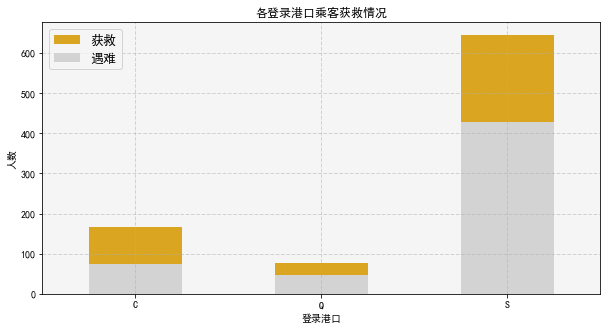

In [36]:
# 画出各港口登录乘客获救情况堆积柱形图
plt.figure(figsize=(10, 5))
plt.gca().set_facecolor('whitesmoke')
embarked_survived_pivot.iloc[0:3, 2].plot(kind='bar', color='goldenrod', label='获救')
embarked_survived_pivot.iloc[0:3, 0].plot(kind='bar', color='lightgrey', label='遇难')
plt.title('各登录港口乘客获救情况')
plt.xticks(rotation=0)
plt.xlabel('登录港口')
plt.ylabel('人数')
plt.legend(facecolor='whitesmoke', fontsize=13)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

S港口的登船乘客数最多，但是被乘客被营救比例却不是最大的；C港口登录的乘客被营救的比例约为一半。

**堂兄弟/妹对是否获救有影响**

In [37]:
# 堂兄弟/妹营救情况的数据透视表
sib_survived_pivot = data_train.pivot_table(values='PassengerId', index=['SibSp', 'Survived'], aggfunc='count')
sib_survived_pivot

PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7

没有观察出特别的规律，作为备选特征。

**孩子/父母有几人对是否营救有影响**

In [38]:
# 孩子/父母营救情况的数据透视表
parch_survived_pivot = data_train.pivot_table(values='PassengerId', index=['Parch', 'Survived'], aggfunc='count')
parch_survived_pivot

PassengerId
Parch Survived             
0     0                 445
      1                 233
1     0                  53
      1                  65
2     0                  40
      1                  40
3     0                   2
      1                   3
4     0                   4
5     0                   4
      1                   1
6     0                   1

没有观察出特别的规律，作为备选特征。

**Ticket是船票编号，是唯一值，对最后结果没有太大的关系，先不纳入特征范畴。**

**观察Cabin的分布情况**

In [39]:
# 统计Cabin属性的分布
cabin = data_train.Cabin.value_counts()
cabin.head()

C23 C25 C27    4
B96 B98        4
G6             4
C22 C26        3
E101           3
Name: Cabin, dtype: int64

将Cabin属性归为类目型，该属性不仅缺失值比较多，而且比较离散。先把Cabin缺失与否作为条件，现在有无Cabin信息这个粒度上看看Survived情况。

In [40]:
# 添加一个Cabin有无信息的标志位列
data_train['Cabin_flag'] = np.where(data_train.Cabin.isnull(), 'No', 'Yes')

In [41]:
# 有无Cabin属性和是否获救的数据透视报表
cabin_survived_pivot = data_train.pivot_table(values='PassengerId', index=['Cabin_flag'], columns=['Survived'], aggfunc='count', margins=True)
cabin_survived_pivot

Survived      0    1  All
Cabin_flag               
No          481  206  687
Yes          68  136  204
All         549  342  891

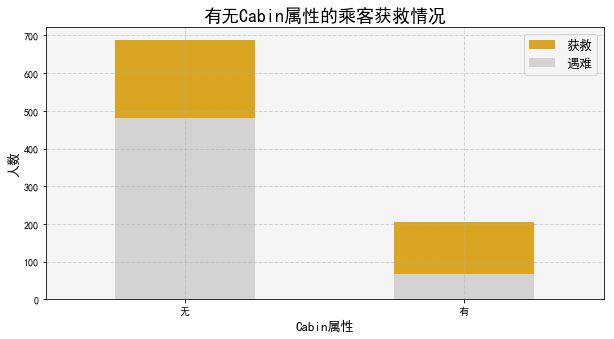

In [42]:
# 有无Cabin属性获救情况的堆积柱形图
plt.figure(figsize=(10, 5))
plt.gca().set_facecolor('whitesmoke')
cabin_survived_pivot.iloc[0:2, 2].plot(kind='bar', color='goldenrod', label='获救')
cabin_survived_pivot.iloc[0:2, 0].plot(kind='bar', color='lightgrey', label='遇难')
plt.title('有无Cabin属性的乘客获救情况', fontsize=18)
plt.xticks([0, 1], ['无', '有'], rotation=0)
plt.xlabel('Cabin属性', fontsize=13)
plt.ylabel('人数', fontsize=13)
plt.legend(facecolor='whitesmoke', fontsize=13)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

上图可以看出，有Cabin属性的乘客被营救的概率要高一点。但是Cabin属性的原因不确定（有可能登记了，但是遗失了），所以先作为备选特征。

### 3.3.3 数据预处理 

经过以上步骤，从总体上了解了下数据，然后对感兴趣的属性进行了单独的深入观察。接下来需要对这些数据做预处理（包括**特征工程**），为接下来的建模做准备。

先从最突出的属性开始，Cabin和Age属性都有缺失值，这对下一步的工作影响太大。

 先处理Calbin属性，按照Cabin属性有无数据，将其处理为Yes和No两种类型。用Cabin属性的标志列覆盖自己就行。

In [43]:
# 将Cabin处理为Yes或No
data_train = data_train.assign(Cabin=data_train.Cabin_flag)

处理Age属性，通常遇到缺失值，会有几种常用的处理方式：
- 如果**缺失的样本占总体数比例极高**，可以直接舍弃掉，作为特征值加如的话，肯能反倒带入noise，影响最后结果。
- 如果**缺失的样本数量适中**，而该属性是非连续性特征属性（比如说类目），那可以吧NaN作为一个新类别，加入到类别特征。
- 如果**缺失的样本数量适中**，而该属性是连续性特征属性，可以考虑给定一个步长（例如此例中的Age属性，可以考虑每隔2/3岁为一个步长），然后将其离散化，最后将NaN作为一个类型，加入到属性类目中。
- 如果**缺失的样本数量较少**，可以尝试根据已有值，拟合一下数据（均值插值、拉格朗日插值等等），补充上。

本例中，后两种方法都可行，这里用**scikit-learn**中的**RandomForest（RandomForest是一个在原始数据中，做不同采样，建立多颗DecisionTree，再进行Average等来降低过拟合现象，提高结果的机器学习算法）**来拟合以下缺失的数据

In [44]:
# 在原始数据中提取已有的数值型特征
age_df = data_train.reindex(columns=['Age', 'Fare', 'Parch', 'SibSp', 'Pclass'])
# 将乘客年龄划分为已知（训练集）和未知（测试集）两部分
age_known = age_df[age_df.Age.notnull()].values
age_unknown = age_df[age_df.Age.isnull()].values
# 划分出训练特征值和训练标签值
X_age = age_known[:, 1:]
y_age = age_known[:, 0]
# 创建训练模型，并用（x_age, y_age)进行训练
rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
rfr.fit(X_age, y_age)
# 用得到的模型根据测试集的特征值来预测其标签值，标签值即为要拟合的缺失年龄
age_predict = rfr.predict(age_unknown[:, 1:])
# 用预测到的标签值来填充缺失年龄
data_train.loc[data_train.Age.isnull(), 'Age'] = age_predict

经过以上两个步骤，数据已经处理为如下格式：

In [45]:
data_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Cabin_flag  
0      0         A/5 21171   7.2500    No        S         No  
1      0          PC 17599  71.2833   Yes        C        Yes  
2      0  STON/O2. 3101282   7.9250    No        S         No  
3      0            113803  53.1000   Yes        S        Yes  
4      0            373450   8.0500    No        S         No

因为逻辑建模时，需要输入的特征都是数值型特征，通常会对类目型的特征因子话。什么叫因子话？例如：

以Cabin特征为例，原本一个属性维度，因其取值可能为Yes或No，而将其平展为Cabin_yes和Cabin_no两个属性：
- **原本Cabin取值为Yes的，在Cabin_yes下取值为1，Cabin_no下取值为0**
- **原本Cabin取值为No的，在Cabin_yes下取值为0，Cabin_no下取值为1**

使用pandas的**get_dummies()**函数来完成属性的因子话工作。

In [46]:
# Cabin属性因子话
dummies_cabin = pd.get_dummies(data_train.Cabin, prefix='Cabin')
# Embarked属性因子话
dummies_embarked = pd.get_dummies(data_train.Embarked, prefix='Embarked')
# Sex属性因子话
dummies_sex = pd.get_dummies(data_train.Sex, prefix='Sex')
# Pclass属性因子话
dummies_pclass = pd.get_dummies(data_train.Pclass, prefix='Pclass')

将因子话后的数据拼接到原始数据中作为模型数据

In [47]:
# 模型数据拼接
data_train_model = pd.concat([data_train, dummies_cabin, dummies_embarked, dummies_pclass, dummies_sex], axis=1)
data_train_model.head(2)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare    ...    Cabin_No Cabin_Yes Embarked_C  \
0      0  A/5 21171   7.2500    ...           1         0          0   
1      0   PC 17599  71.2833    ...           0         1          1   

   Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  Sex_female  Sex_male  
0           0           1         0         0         1           0         1  
1           0           0         1         0         0           1         0  

[2 rows x 23 columns]

删除不必要的数据列

In [48]:
# 删除不必要的数据列
data_train_model.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Cabin_flag'], axis=1, inplace=True)

这样所有属性值都有了，而且都是数值类型的。处理完成后的数据如下所示：

In [49]:
data_train_model.head()

PassengerId  Survived   Age  SibSp  Parch     Fare  Cabin_No  Cabin_Yes  \
0            1         0  22.0      1      0   7.2500         1          0   
1            2         1  38.0      1      0  71.2833         0          1   
2            3         1  26.0      0      0   7.9250         1          0   
3            4         1  35.0      1      0  53.1000         0          1   
4            5         0  35.0      0      0   8.0500         1          0   

   Embarked_C  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  \
0           0           0           1         0         0         1   
1           1           0           0         1         0         0   
2           0           0           1         0         0         1   
3           0           0           1         1         0         0   
4           0           0           1         0         0         1   

   Sex_female  Sex_male  
0           0         1  
1           1         0  
2           1         0  
3           1         0  
4           0         1

观察上述数据，**由于Age和Fare属性，随乘客变化数值变化较大，在进行逻辑回归或梯度下降时，各属性值之间的scale差距太大，会对收敛速度造成影响，甚至不收敛**。所以，使用scikit-learn内的preprocessing模块对这两个属性做一个scaling，所谓scaling，即收敛，将一些变化幅度较大的特征收敛到$[-1, 1]$内。

In [50]:
# 实例化收敛对象
scaler = preprocessing.StandardScaler()
# 计算Age属性列的均值和标准差
age_scale_param = scaler.fit(data_train_model.Age.values.reshape(-1, 1))
# 将收敛结果新增到Age_scaled列
data_train_model['Age_scaled'] = scaler.fit_transform(data_train_model.Age.values.reshape(-1, 1), age_scale_param)
# 计算Fare属性列的均值和标准差
fare_scale_param = scaler.fit(data_train_model.Fare.values.reshape(-1, 1))
# 将收敛结果新增到Fare_scaled列
data_train_model['Fare_scaled'] = scaler.fit_transform(data_train_model.Fare.values.reshape(-1, 1), fare_scale_param)

收敛完成后，数据格式如下：

In [51]:
data_train_model.head()

PassengerId  Survived   Age  SibSp  Parch     Fare  Cabin_No  Cabin_Yes  \
0            1         0  22.0      1      0   7.2500         1          0   
1            2         1  38.0      1      0  71.2833         0          1   
2            3         1  26.0      0      0   7.9250         1          0   
3            4         1  35.0      1      0  53.1000         0          1   
4            5         0  35.0      0      0   8.0500         1          0   

   Embarked_C  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  \
0           0           0           1         0         0         1   
1           1           0           0         1         0         0   
2           0           0           1         0         0         1   
3           0           0           1         1         0         0   
4           0           0           1         0         0         1   

   Sex_female  Sex_male  Age_scaled  Fare_scaled  
0           0         1   -0.561380    -0.502445  
1           1         0    0.613171     0.786845  
2           1         0   -0.267742    -0.488854  
3           1         0    0.392942     0.420730  
4           0         1    0.392942    -0.486337

最后，将需要的属性值抽出来，转换成回归模型能够处理的格式，就能建模了。

# 4 数据建模 

## 4.1 模型建立

把需要的特征字段提取出来，转换成numpy格式，使用scikit-learn中的LogistickRegression建模。

In [52]:
# 用正则表达式提取需要的特征
train_model = data_train_model.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Pclass_.*|Sex_.*')
# 转化为numpy数组
train_model_np = train_model.values
# 划分训练集特征值和标签
X_train = train_model_np[:, 1:]
y_train = train_model_np[:, 0]
# 初始化逻辑回归模型
clf = LogisticRegression(solver='liblinear', C=1.0, penalty='l1', tol=1e-6)
# 使用（X_train, y）进行训练
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=1e-06, verbose=0,
                   warm_start=False)

得到了一个模型。现在还不能直接进行测试集预测，因为测试集的数据还没有像训练集那样处理。

## 4.2 测试集数据处理

数据加载

In [53]:
# 加载测试集数据
data_test = pd.read_csv('./data/lgregression/test.csv')
data_test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [54]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [55]:
data_test.Fare.isnull().sum()

1

观察上述结果，发现和训练集一样，测试集的Age和Cabin属性都存在缺失值，可以类似的方法进行处理。而且发现Fare属性有一条空值。接下来对测试集数据进行处理。

In [56]:
# 将Fare的空值替换为0
data_test.loc[data_test.Fare.isnull(), 'Fare'] = 0

用处理训练集Age属性生成的随机森林模型，来预测测试集缺失的Age属性：

In [57]:
# 从原始数据中提取已有的数值型特征
test_age_df = data_test.reindex(columns=['Age', 'Fare', 'Parch', 'SibSp', 'Pclass'])
# 提取缺失年龄的数据
age_null = test_age_df[test_age_df.Age.isnull()].values
# 构建测试集特征值
X_r = age_null[:, 1:]
# 用训练集构建的随机森林模型来预测测试集
test_age_predict = rfr.predict(X_r)
# 用预测的数据补全缺失的Age属性
data_test.loc[data_test.Age.isnull(), 'Age'] = test_age_predict

将Cabin特征按照是否有记录划分为Yes和No：

In [58]:
# 将有记录的Cabin特征替换为Yes
data_test.loc[data_test.Cabin.notnull(), 'Cabin'] = 'Yes'
# jiang无记录的Cabin特征替换为No
data_test.loc[data_test.Cabin.isnull(), 'Cabin'] = 'No'

因子话类目型特征：

In [59]:
# Cabin属性因子话
test_dummies_cabin = pd.get_dummies(data_test.Cabin, prefix='Cabin')
# Embarked属性因子话
test_dummies_embarked = pd.get_dummies(data_test.Embarked, prefix='Embarked')
# Sex属性因子话
test_dummies_sex = pd.get_dummies(data_test.Sex, prefix='Sex')
# Pclass属性因子话
test_dummies_pclass = pd.get_dummies(data_test.Pclass, prefix='Pclass')

合并数据：

In [60]:
# 模型数据拼接
data_test_model = pd.concat([data_test, test_dummies_cabin, test_dummies_embarked, test_dummies_pclass, test_dummies_sex], axis=1)
data_test_model.head(2)

PassengerId  Pclass                              Name     Sex   Age  SibSp  \
0          892       3                  Kelly, Mr. James    male  34.5      0   
1          893       3  Wilkes, Mrs. James (Ellen Needs)  female  47.0      1   

   Parch  Ticket    Fare Cabin    ...    Cabin_No  Cabin_Yes  Embarked_C  \
0      0  330911  7.8292    No    ...           1          0           0   
1      0  363272  7.0000    No    ...           1          0           0   

   Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  Sex_female  Sex_male  
0           1           0         0         0         1           0         1  
1           0           1         0         0         1           1         0  

[2 rows x 21 columns]

In [61]:
# 删除不必要的数据列
data_test_model.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
data_test_model.head()

PassengerId   Age  SibSp  Parch     Fare  Cabin_No  Cabin_Yes  Embarked_C  \
0          892  34.5      0      0   7.8292         1          0           0   
1          893  47.0      1      0   7.0000         1          0           0   
2          894  62.0      0      0   9.6875         1          0           0   
3          895  27.0      0      0   8.6625         1          0           0   
4          896  22.0      1      1  12.2875         1          0           0   

   Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  Sex_female  Sex_male  
0           1           0         0         0         1           0         1  
1           0           1         0         0         1           1         0  
2           1           0         0         1         0           0         1  
3           0           1         0         0         1           0         1  
4           0           1         0         0         1           1         0

使用训练集的收敛模型来收敛测试集的Age和Fare属性：

In [62]:
# 收敛测试集的Age属性
data_test_model['Age_scaled'] = scaler.fit_transform(data_test_model.Age.values.reshape(-1, 1), age_scale_param)
# 收敛测试集的Fare属性
data_test_model['Fare_scaled'] = scaler.fit_transform(data_test_model.Fare.values.reshape(-1, 1), fare_scale_param)
data_test_model.head()

PassengerId   Age  SibSp  Parch     Fare  Cabin_No  Cabin_Yes  Embarked_C  \
0          892  34.5      0      0   7.8292         1          0           0   
1          893  47.0      1      0   7.0000         1          0           0   
2          894  62.0      0      0   9.6875         1          0           0   
3          895  27.0      0      0   8.6625         1          0           0   
4          896  22.0      1      1  12.2875         1          0           0   

   Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  Sex_female  Sex_male  \
0           1           0         0         0         1           0         1   
1           0           1         0         0         1           1         0   
2           1           0         0         1         0           0         1   
3           0           1         0         0         1           0         1   
4           0           1         0         0         1           1         0   

   Age_scaled  Fare_scaled  
0    0.307521    -0.496637  
1    1.256241    -0.511497  
2    2.394706    -0.463335  
3   -0.261711    -0.481704  
4   -0.641199    -0.416740

提取需要的特征，来做最后一步的数据预测：

In [63]:
# 用正则表达式提取需要的特征
test_model = data_test_model.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Pclass_.*|Sex_.*')
test_model.head()

SibSp  Parch  Cabin_No  Cabin_Yes  Embarked_C  Embarked_Q  Embarked_S  \
0      0      0         1          0           0           1           0   
1      1      0         1          0           0           0           1   
2      0      0         1          0           0           1           0   
3      0      0         1          0           0           0           1   
4      1      1         1          0           0           0           1   

   Pclass_1  Pclass_2  Pclass_3  Sex_female  Sex_male  Age_scaled  Fare_scaled  
0         0         0         1           0         1    0.307521    -0.496637  
1         0         0         1           1         0    1.256241    -0.511497  
2         0         1         0           0         1    2.394706    -0.463335  
3         0         0         1           0         1   -0.261711    -0.481704  
4         0         0         1           1         0   -0.641199    -0.416740

用训练集训练出的模型来预测测试集乘客的获救情况：

In [64]:
# 预测测试集乘客的获救情况
survived_predict = clf.predict(test_model.values)
# 测试集乘客获救情况预测结果
result_survived = pd.DataFrame({'PassengerId': data_test_model.PassengerId, 'Survived': survived_predict})
result_survived.head()

PassengerId  Survived
0          892       0.0
1          893       0.0
2          894       0.0
3          895       0.0
4          896       1.0

这是经过简单数据处理后得出的一个baseline模型。

# 5 逻辑回归模型优化

## 5.1 模型系数关联分析

上述得到的只是baseline模型，如果看过[Andrew Ng](https://www.coursera.org/learn/machine-learning#instructors)老师的机器学习课程，应该分析模型现在的状态，是**过拟合/欠拟合？**。以确定需要更多的特征还是更多的数据，或者其它操作。

不过在现在的场景下，这个baseline模型还有些粗糙，先再挖掘挖掘：
- 首先Name和Ticket两个属性完全被舍弃掉了。原因是这两个属性，几乎每一条记录都是一个不同的值，并没有找到很直接的处理方式。
- 用随机森林来拟合Age属性的缺失值也并非完全靠谱，因为是依据已有的其它数值型属性来预测补全的。以日常经验，小朋友和老人可能会得到更多的照顾，这样年龄作为一个连续值，给一个固定系数，应该和年龄是一个正相关或负相关，似乎体现不出两头受照顾的情况。所以，说不定把年龄离散化，按区段作为类别属性会更合适一些。

**关联模型系数和对应特征：**

In [65]:
# 将回归系数和对应特征关联起来
coef_feature = pd.DataFrame({'coef': list(clf.coef_.T), 'feature': test_model.columns})
coef_feature

coef      feature
0   [-0.344235528971]        SibSp
1   [-0.104915826727]        Parch
2               [0.0]     Cabin_No
3    [0.902107991028]    Cabin_Yes
4               [0.0]   Embarked_C
5               [0.0]   Embarked_Q
6   [-0.417264057497]   Embarked_S
7    [0.341159782526]     Pclass_1
8               [0.0]     Pclass_2
9    [-1.19412997666]     Pclass_3
10    [1.95657012692]   Sex_female
11  [-0.677421561652]     Sex_male
12   [-0.52376666417]   Age_scaled
13  [0.0844347023055]  Fare_scaled

在逻辑回归介绍两篇文章内可以知道：**回归系数为正的特征，和最后的结果是一个正相关，反之为负相关。**

首先观察权重比较大的特征：
- **Sex**属性，female会极大提高获救后的概率，而male会很大的拉低这个概率。
- **Pclass**属性，一等舱的乘客最后获救的概率会上升，而三等舱的乘客会拉低这个概率。
- **Cabin**属性，有Cabin属性的乘客会拉升获救概率。
- **Age**属性，其为一个负相关，在该模型中，年龄越小越有获救的优先权（还得回元数据看看这个是否合理）
- **Embarked**属性，S港口登船的乘客很大程度上拉低了获救概率，另外两个港口没有什么作用（从之前的统计图中,并么有看到S港口登船乘客获救率很低，所以可以考虑将这个特征去掉）
- **Fare**属性，有小幅度的正相关（并不意味该特征作用不大，有可能是细化程度还不够，例如，将其离散化再分至各乘客等级？）

观察结束后，现在有一些想法，但是怎样才知道，哪些优化方法是promising的呢？

因为test.csv并没有Survived字段（这是最后需要预测的结果），无法在这份数据上评定模型在该场景下的效果。所以我们可以做交叉验证来评估模型。

## 5.2 交叉验证

在通常情况下，这样做cross validation：将train.csv（数据处理完成后，逻辑回归可用的数据，即train_model）分成两部分，一部分用来训练我们需要的模型；另一部数据用来看我们预测算法的效果。

这里使用scikit-learn的cross_validation来完成小数据集上的这个工作:
- **clf：训练集建立的逻辑回归模型**
- **X_train：训练集特征值**
- **y_train：训练集标签**

In [66]:
# 对baselines模型进行交叉验证
cross_val_score(clf, X_train, y_train, cv=5)

array([ 0.81564246,  0.81564246,  0.78651685,  0.78651685,  0.81355932])

通过交叉验证得出的模型准确率在0.8左右。

既然做交叉验证，干脆把交叉验证里的bad case拿出来单独观察，看能否发现什么使得这些乘客被判定错误。再把bad case上得到的想法和前面的回归系数关联分析结合在一起，逐个尝试。

In [67]:
# 按照（训练数据：验证数据）=（7：3）的比例切割train_model数据
split_train, split_cv = train_test_split(data_train_model, test_size=0.3, random_state=42)
# 提取训练集数据
train_df = split_train.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Pclass_.*|Sex_.')
#  构建一个新的模型
clf_cv = LogisticRegression(solver='liblinear', C=1.0, penalty='l1', tol=1e-6)
# 训练模型
clf_cv.fit(train_df.values[:, 1:], train_df.values[:, 0])
# 提验证集集数据
cv_df = split_cv.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Pclass_.*|Sex_.')
# 对验证数据进行预测
cv_df_predict = clf_cv.predict(cv_df.values[:, 1:])
# 在data_train数据中筛选出bad case，即预测错误的记录
bad_case = data_train.loc[data_train.PassengerId.isin(split_cv[cv_df_predict != cv_df.Survived]['PassengerId'])]

In [68]:
bad_case.head()

PassengerId  Survived  Pclass  \
23           24         1       1   
25           26         1       3   
49           50         0       3   
55           56         1       1   
65           66         1       3   

                                                 Name     Sex        Age  \
23                       Sloper, Mr. William Thompson    male  28.000000   
25  Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...  female  38.000000   
49      Arnold-Franchi, Mrs. Josef (Josefine Franchi)  female  18.000000   
55                                  Woolner, Mr. Hugh    male  44.064830   
65                           Moubarek, Master. Gerios    male  17.099916   

    SibSp  Parch  Ticket     Fare Cabin Embarked Cabin_flag  
23      0      0  113788  35.5000   Yes        S        Yes  
25      1      5  347077  31.3875    No        S         No  
49      1      0  349237  17.8000    No        S         No  
55      0      0   19947  35.5000   Yes        S        Yes  
65      1      1    2661  15.2458    No        C         No

用bad case结合前面的系数关联分析，可以印证一部分系数关联分析的猜测，这些优化的想法优先级可以放高一些。

下列是一些可以优化的操作：
- Age属性不使用现在的拟合方式，而是根据名称中的Mr、Mrs、Miss等的平均值来进行填充。
- Age不做成一个连续值属性，而是使用步长进行离散，变成离散的类目特征。
- Cabin属性可以再细化一些，对有记录的Cabin'属性，将其分为字母部分和数字部分。
- Pclass和Sex属性太重要了，尝试将其组合出一个属性来试试，这也是另外一种程度的细化。
- 单加一个Child属性，Age<=12，其值为1，反之为0。
- 如果名字有Mrs，而且Parch>1的，猜想其为一个母亲，其获救的概率应该会提高，所以新增一个Mother属性，在此情况下其值为1，反之为0。
- 把堂兄/堂妹、Parch和自己加在一起，新增一个Family_size属性，考虑到大家族可能对最后结果的影响
- Name是一个一直没有触碰的属性，可以做一些简单的处理，比如男性姓名中带有某些字眼的（Capt、Don、Major、Sir）可以归为一个Title，女性姓名也可做同样的处理。

经过上述的特征工程，就可以使用手头上的**train_df**和**cv_df**来验证这些特征的tricks是否有效了，这一个漫长的过程。

## 5.3 Learning Curves 

[Learning Curves（学习曲线）介绍](https://blog.csdn.net/GitzLiu/article/details/82634295)

有一个很可能发生的问题是，在不断的做Freature Engineering后，产生的特征原来越多，用这些特征去训练模型，会**对训练集拟合的越来越好，同时也在丧失泛化能力，**从而在测试集上表现不佳，就是发生**过拟合**现象。

从另一个角度说，如果模型在测试集上的表现不好，除了是**过拟合**现象，也有可能是**欠拟合**现象。也就是说，在训练集上，模型拟合的也不是那么好。

形象的解释过拟合和欠拟合：
- **过拟合：**就像班上学数学比较刻板的同学，老师讲的题目，一字不漏的全记下来，于是老师出一样的题目，分分钟精确出结果；但是，数学考试时，由于总是碰到新的题目，所以成绩不怎么样。
- **欠拟合：**就像班上学数学比较差的同学，连老师讲的题目都记不住，于是连老师出的题目复习都做不好，考试可想而知。

在机器学习上，对**过拟合**和**欠拟合**的处理方法是不一样的：
- **过拟合：**
    - 做一下特征选择（Feature Selection）,挑出较好的Feature来做Training。
    - 提供更多的数据，从而弥补原始数据的偏斜（bias）问题，学习到的model也会更精确。
- **欠拟合：**需要更多的Feature，更复杂的模型来提高准确度。

用scikit-lean中的learning_curve来帮助分辨模型的状态。接下来画出最初是得到的baseline model的learning curve，基本思路是用learning_curve得到training_score和cv_score，然后用matplotlib画出learning_curve：

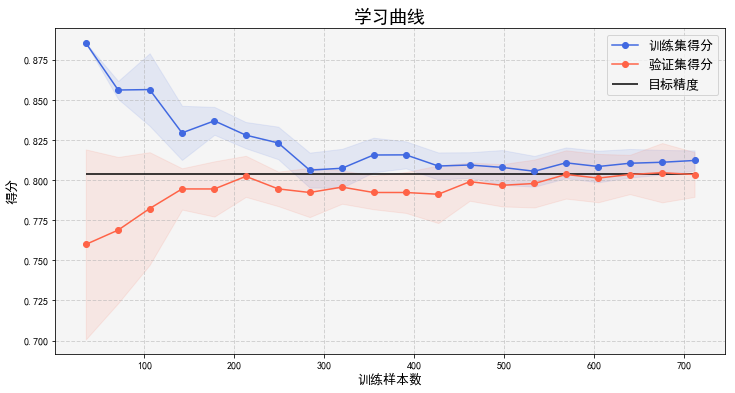

In [69]:
# 设置训练集大小，每次以0.05比例的增，一共训练20次
train_sizes = np.linspace(.05, 1., 20)
# 使用learning_curve()函数得到training_score和cv_score
#     参数解释：
#     -------------------------------------------------------------
#     estimator：使用的分类器，即模型，本例中为用训练集训练的clf
#     X：输入的训练集特征值（feature），其为numpy类型，本例中为X_train
#     y：输入的训练集标签（target vector），其为numpy类型，本例中为y_train
#     cv：做cross-validations时，将数据分成的份数（默认为3，将其设定为5，不然会出警告），其中一份作为cv数据，剩余n-1份作为training
#     n_jobs：并行的任务数（默认为1）
train_sizes_abs, train_scores, test_scores = learning_curve(estimator=clf,
                                                            X=X_train,
                                                            y=y_train,
                                                            cv=5,
                                                            train_sizes=train_sizes,
                                                            n_jobs=1,
                                                            verbose=0
                                                           )
# 为了在学习线周围画出标准差范围，分别求出train_score、test_scores的均值和标准差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
# 设置画布
plt.figure(figsize=(12, 6))
plt.gca().set_facecolor('whitesmoke')
# 画出训练集得分曲线和误差区间
plt.plot(train_sizes_abs, train_scores_mean, '-o', color='royalblue', label='训练集得分')
plt.fill_between(train_sizes_abs, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, color='royalblue', alpha=0.1)
# 画出验证集得分曲线和误差区间
plt.plot(train_sizes_abs, test_scores_mean, '-o', color='tomato', label='验证集得分')
plt.fill_between(train_sizes_abs, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, color='tomato', alpha=0.1)
# 画出desired accuracy
midpoint = ((train_scores_mean[-1]+train_scores_std[-1]) + (test_scores_mean[-1]-test_scores_std[-1])) / 2
plt.hlines(midpoint, train_sizes_abs[0], train_sizes_abs[-1], color='black', linestyle='solid', label='目标精度')
plt.title('学习曲线', fontsize=18)
plt.xlabel('训练样本数', fontsize=13)
plt.ylabel('得分', fontsize=13)
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.legend(facecolor='whitesmoke', fontsize=13)
plt.show()

在实际数据上看，得到的learning curve并没有理论推导那么光滑，但是大致可以看出训练集和交叉验证集上的得分曲线还是符合预期的。

就目前情况来看，模型并不处于overfitting状态（过拟合状态表现为训练集上得分高，而交叉验证集上得分要低很多，中间的gap比较大）。因此，可以再做一些Feature Engineering，添加一些新特征或者组合特征到模型中。

## 5.4 模型融合（Model Ensemble） 

形象的解释模型融合：
- 知识问答综艺节目中，在求助现场观众时，让观众投票，将票数最高的答案作为自己的答案。每个人都一个判定结果，最后相信答案在大多数人手中。
- 你和班上某数学大神关系很好，每次作业都模仿他的，于是绝大多情况下，他做对了，你也做对了。某一天，大神犯糊涂，写错了一个数，你也只能跟着错了。
- 你和班上4个数学大神的关系很好，每次把他们的作业拿来对比一下，再自己做。如果哪天某个大神的写错了，但是另外四个写对了，你肯定相信另外四个人的时正确答案。

最简单的模型融合就是这个意思，比如说分类问题，**有一堆在同一份数据集上训练得到的分类器（比如Logistic Regression、SVM、KNN、Random Forest、神经网络等等），让其分别做判定，然后对结果做投票统计，取得票最高的结果为最后结果。**

模型融合可以很好的缓解训练过程中产生的拟合问题，从而对结果准确度的提升有一定的帮助。目前，只使用了Logistic Regression进行了拟合，如果还想使用上述的思想来提高拟合结果，那么该怎么办？

既然在模型上没有选择，那么就在数据上想办法。如果模型出现过拟合现象，一定是在训练集上拟合过度造成的。那么：
- **不用训练集的全部数据，每次取其一个子集（subset）来做训练。这样，虽然用的是同一个算法，但是得到的模型却是不同的。**
- **因为没有任何一份数据是全的，即使出现过拟合现象，也是在子训练集上出现的过拟合。然后再做一个融合，可能对最后的结果有一定的帮助。**

上述所描述的就是常用的Bagging。可以使用scikit-learn中的Bagging来实现上述思路：

In [70]:
# 新建一个模型对象
clf_bag = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
# 创建BaggingRegressor对象
bagging_clf = BaggingRegressor(base_estimator=clf_bag, 
                               n_estimators=20, 
                               max_samples=0.8, 
                               max_features=1.0, 
                               bootstrap=True, 
                               bootstrap_features=False, 
                               n_jobs=-1
                              )
bagging_clf.fit(X_train, y_train)
# 使用融合模型和预测测试集
bag_survived_predict = bagging_clf.predict(test_model.values)
bag_result_survived = pd.DataFrame({'PassengerId': data_test_model.PassengerId, 'Survived': bag_survived_predict.astype(np.int32)})
bag_result_survived.head(10)

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0

# 6 总结

对于任何一个机器学习问题，先构建一个baseline的model出来，再进行后续的分析，一步一步提高。

在问题的分析过程中：
- **对数据的认识非常重要**
- **数据中的特殊点/离群点的分析和处理非常重要**
- **特征工程（Feature Engineering）非常重要**
- **模型融合（Model Ensemble）非常重要**